In [74]:
!python --version
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

Python 3.6.8 :: Anaconda, Inc.


In [75]:
df = pd.read_csv('bioactivity_data.csv')
df = df[df.canonical_smiles.notna()]
df_no_smiles = df.drop(columns='canonical_smiles')
smiles = []
for i in df.canonical_smiles.tolist():
    cpd = str(i).split('.')
    cpd_longest = max(cpd, key=len)
    smiles.append(cpd_longest)
    
smiles = pd.Series(smiles, name='canonical_smiles')
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1)
df_clean_smiles

,index,molecule_chembl_id,standard_value,class,canonical_smiles
0,0,CHEMBL9650,30.0,active,CCC(C)[C@H](NC(=O)[C@@H]1CCCN1[P@@](=O)(OC)[C@...
1,1,CHEMBL273396,93.0,active,CCC(C)[C@H](NC(=O)[C@@H]1CCCN1[P@@](=O)(OC)[C@...
2,2,CHEMBL108102,42.0,active,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)C(O)CN(Cc...
3,3,CHEMBL322033,1000.0,active,COC(=O)N(C)C(C(=O)N[C@@H](Cc1ccccc1)[C@H](O)CN...
4,4,CHEMBL20143,4.0,active,CC(C)[C@H](NC(=O)OCc1ccccc1)C(=O)NC(Cc1ccc(OCc...
...,...,...,...,...,...
2462,3173,CHEMBL388957,2800.0,intermediate,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(N)=O)NC(=O)CCC...
2463,3174,CHEMBL376817,5100.0,intermediate,COC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)...
2464,3175,CHEMBL224644,5300.0,intermediate,CC[C@H](C)[C@H](NC(=O)CCCOc1ccc2ccc(OCCCC(=O)N...
2465,3178,CHEMBL405969,290.0,active,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...


## Calculate Lipinski descriptors
Chistopher Lipinski came up with a set of rule-of-thumb for evaluating the druglikeness of compounds.
This is based on the Absorbtion, Distribution, Metabolism and Excretion (ADME) that is also know as the pharmokinetic profile.
Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is know as the Rule-Of-Five or Lipinski's-Rule which states the following:

- Molecular weight < 500 Dalton
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10

In [76]:
def lipinski(smiles, verbose=False):
    moldata=[]
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)
        
    baseData = np.arange(1,1)
    i=0
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
        
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])
        
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i += 1
        
    columnNames=['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)
    
    return descriptors

In [77]:
df_lipinski = lipinski(df.canonical_smiles)

In [78]:
print(df_lipinski.size)
print(df.size)

9868
12335


In [79]:
df_combined = pd.concat([df, df_lipinski], axis=1)
df_combined.head()

,index,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,0,CHEMBL9650,CCC(C)[C@H](NC(=O)[C@@H]1CCCN1[P@@](=O)(OC)[C@...,30.0,active,694.811,3.0471,5.0,8.0
1,1,CHEMBL273396,CCC(C)[C@H](NC(=O)[C@@H]1CCCN1[P@@](=O)(OC)[C@...,93.0,active,694.811,3.0471,5.0,8.0
2,2,CHEMBL108102,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)C(O)CN(Cc...,42.0,active,617.719,2.5085,5.0,8.0
3,3,CHEMBL322033,COC(=O)N(C)C(C(=O)N[C@@H](Cc1ccccc1)[C@H](O)CN...,1000.0,active,633.831,3.4339,3.0,8.0
4,4,CHEMBL20143,CC(C)[C@H](NC(=O)OCc1ccccc1)C(=O)NC(Cc1ccc(OCc...,4.0,active,681.733,4.6737,4.0,7.0


## Convert IC50 to pIC50
To allow IC<sub>50</sub> data to be more uniformly distributed, we will convert IC<sub>50</sub> to the negative logarithmic scale which is essentially -log10(IC<sub>50</sub>).

This custom pIC50() will accept a Dataframe as input and will:
- Take the IC<sub>50</sub> values from the standard_value column and converts it from nM to M by multiplying the value by 10^-9
- Take the molar value and apply -log10
- Delete the standard_value column and create a new pIC50 column

In [80]:
def pIC50(input):
    pIC50=[]
    
    for i in input['standard_value_norm']:
        molar = i*(10**-9)
        pIC50.append(-np.log10(molar))
        
    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
    
    return x

In [81]:
df_combined.standard_value.describe()

count    2.467000e+03
mean     1.917615e+04
std      1.780175e+05
min      1.000000e-02
25%      2.699000e+00
50%      3.700000e+01
75%      1.000000e+03
max      5.000000e+06
Name: standard_value, dtype: float64

In [82]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [83]:
df_norm = norm_value(df_combined)
df_norm.head()

,index,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,0,CHEMBL9650,CCC(C)[C@H](NC(=O)[C@@H]1CCCN1[P@@](=O)(OC)[C@...,active,694.811,3.0471,5.0,8.0,30.0
1,1,CHEMBL273396,CCC(C)[C@H](NC(=O)[C@@H]1CCCN1[P@@](=O)(OC)[C@...,active,694.811,3.0471,5.0,8.0,93.0
2,2,CHEMBL108102,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)C(O)CN(Cc...,active,617.719,2.5085,5.0,8.0,42.0
3,3,CHEMBL322033,COC(=O)N(C)C(C(=O)N[C@@H](Cc1ccccc1)[C@H](O)CN...,active,633.831,3.4339,3.0,8.0,1000.0
4,4,CHEMBL20143,CC(C)[C@H](NC(=O)OCc1ccccc1)C(=O)NC(Cc1ccc(OCc...,active,681.733,4.6737,4.0,7.0,4.0


In [84]:
df_norm.standard_value_norm.describe()

count    2.467000e+03
mean     1.917615e+04
std      1.780175e+05
min      1.000000e-02
25%      2.699000e+00
50%      3.700000e+01
75%      1.000000e+03
max      5.000000e+06
Name: standard_value_norm, dtype: float64

In [85]:
df_final = pIC50(df_norm)
df_final.head()

,index,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,CHEMBL9650,CCC(C)[C@H](NC(=O)[C@@H]1CCCN1[P@@](=O)(OC)[C@...,active,694.811,3.0471,5.0,8.0,7.522879
1,1,CHEMBL273396,CCC(C)[C@H](NC(=O)[C@@H]1CCCN1[P@@](=O)(OC)[C@...,active,694.811,3.0471,5.0,8.0,7.031517
2,2,CHEMBL108102,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)C(O)CN(Cc...,active,617.719,2.5085,5.0,8.0,7.376751
3,3,CHEMBL322033,COC(=O)N(C)C(C(=O)N[C@@H](Cc1ccccc1)[C@H](O)CN...,active,633.831,3.4339,3.0,8.0,6.000000
4,4,CHEMBL20143,CC(C)[C@H](NC(=O)OCc1ccccc1)C(=O)NC(Cc1ccc(OCc...,active,681.733,4.6737,4.0,7.0,8.397940


In [86]:
df_final.pIC50.describe()

count    2467.000000
mean        7.270863
std         1.726544
min         2.301030
25%         6.000000
50%         7.431798
75%         8.568797
max        11.000000
Name: pIC50, dtype: float64

In [87]:
#Remove intermediate bioactivity class and save
df_final = df_final[df_final['class'] != 'intermediate']
df_final.to_csv('hiv_bioactivitydata_pIC50.csv')

## EDA

In [88]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

## Frequency plot of the 2 bioactivity classes

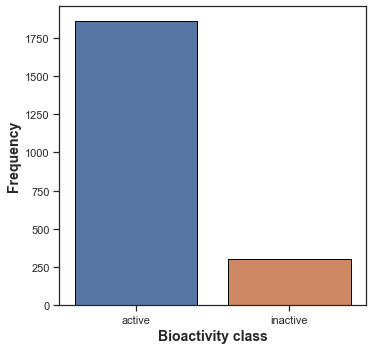

In [89]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_final, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

## Scatter plot of MW vs LogP
It can be seen that the two bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP

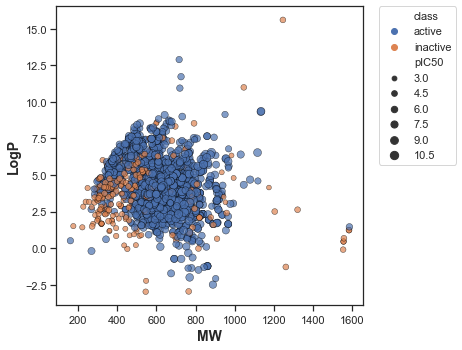

In [90]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_final, hue='class',
                size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

# Box Plots

## pIC50 Value

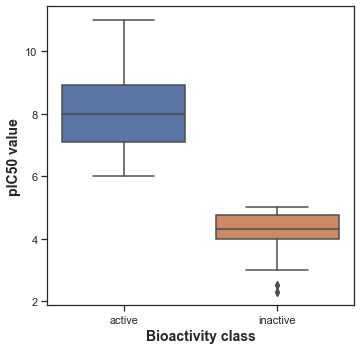

In [91]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y='pIC50', data=df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

## Statistical analysis | Mann-Whitney U Test

In [96]:
def mannwhitney(descriptor, verbose=False):
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu

    # seed the random number generator
    seed(1)

    # actives and inactives
    selection = [descriptor, 'class']
    df = df_final[selection]
    active = df[df['class'] == 'active']
    active = active[descriptor]

    selection = [descriptor, 'class']
    df = df_final[selection]
    inactive = df[df['class'] == 'inactive']
    inactive = inactive[descriptor]

    # compare samples
    stat, p = mannwhitneyu(active, inactive)
    #print('Statistics=%.3f, p=%.3f' % (stat, p))

    #interpret
    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'
  
    results = pd.DataFrame({'Descriptor':descriptor,
                            'Statistics':stat,
                            'p':p,
                            'alpha':alpha,
                            'Interpretation':interpretation}, index=[0])
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)

    return results

In [97]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,8.584341e-172,0.05,Different distribution (reject H0)


## MW

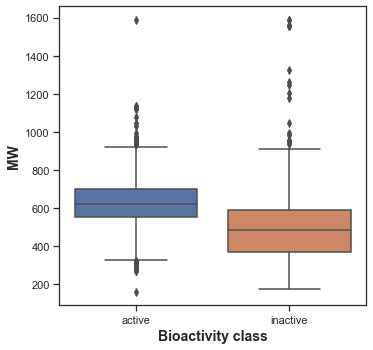

In [101]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y='MW', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [103]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,154038.0,7.241223e-37,0.05,Different distribution (reject H0)


## LogP

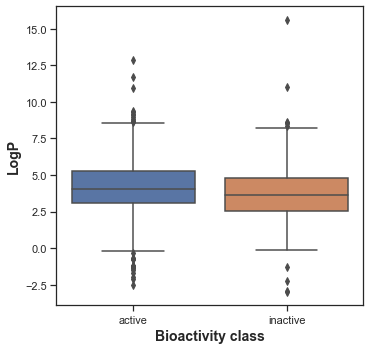

In [104]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y='LogP', data=df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [105]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,240741.5,0.000028,0.05,Different distribution (reject H0)


## Num H Donors

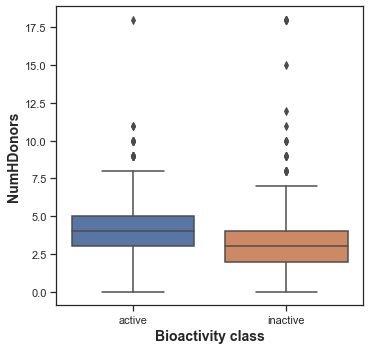

In [106]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y = 'NumHDonors', data=df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plt_NumHDonors.pdf')

In [107]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,205103.0,6.708426e-15,0.05,Different distribution (reject H0)


## Num H Acceptors

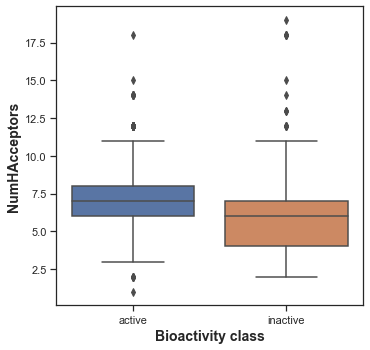

In [108]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y='NumHAcceptors', data=df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [110]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,185235.0,2.798340e-22,0.05,Different distribution (reject H0)


## Interpretation of Statistical results

### pIC50 values
Taking a look at pIC50 values, the actives and inactives displayed statistically significant difference, which is to be expected since threshold values were used to define actives and inactives

### Lipinski's descriptors
All of the 4 Lipinski's descriptors exhibited statistically significant difference between the actives and the inactives